In [1]:
import os

import numpy as np
from PIL import Image
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import xml.etree.ElementTree as et

import tensorflow as tf
from tensorflow import keras
import re
import shutil

## 데이터 준비

In [2]:
cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, 'data/crawled_images/annotated')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

In [3]:
train_img_files = [imgname for imgname in os.listdir(train_dir) if os.path.splitext(imgname)[-1] == '.jpg']
train_ano_files = [anoname for anoname in os.listdir(train_dir) if os.path.splitext(anoname)[-1] == '.xml']

test_img_files = [imgname for imgname in os.listdir(test_dir) if os.path.splitext(imgname)[-1] == '.jpg']
test_ano_files = [anoname for anoname in os.listdir(test_dir) if os.path.splitext(anoname)[-1] == '.xml']

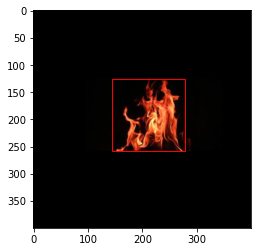

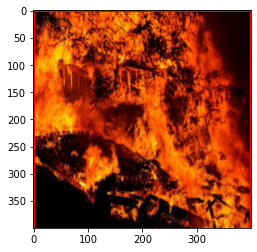

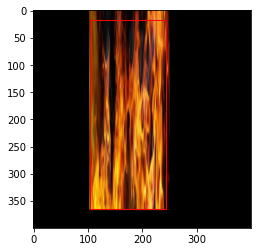

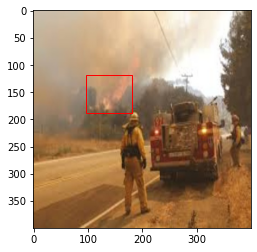

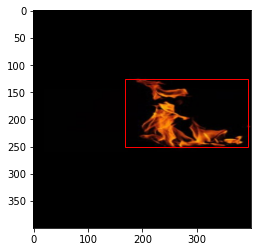

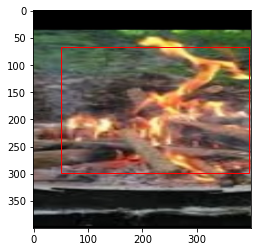

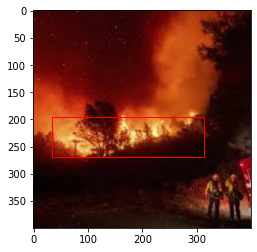

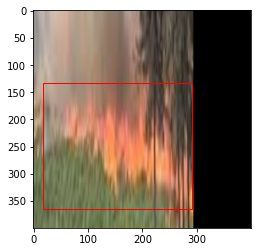

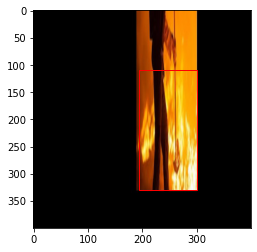

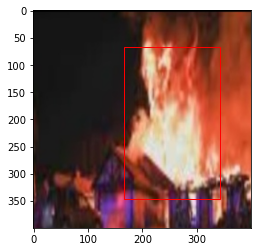

In [4]:
for i in range(10):
    rnd_idx = random.randint(1, len(train_img_files))
    fname = train_img_files[rnd_idx]
    fpath = os.path.join(train_dir, fname)
    image = Image.open(fpath)
    image = np.array(image)
    
    bbox_name = os.path.splitext(fname)[0]+'.xml'
    bbox_path = os.path.join(train_dir, bbox_name)
    tree = et.parse(bbox_path)
    
    
    width = float(tree.find('./size/width').text)
    height = float(tree.find('./size/height').text)
    
    xmin = float(tree.find('./object/bndbox/xmin').text)
    ymin = float(tree.find('./object/bndbox/ymin').text)
    xmax = float(tree.find('./object/bndbox/xmax').text)
    ymax = float(tree.find('./object/bndbox/ymax').text)
    
    rect_x = xmin
    rect_y = ymin
    rect_w = xmax-xmin
    rect_h = ymax-ymin
    
    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
    plt.subplot(10,1,i+1)
    plt.axes().add_patch(rect)
    plt.imshow(image)
    plt.show()


In [5]:
for img in train_img_files:
    img_path = os.path.join(train_dir,img)
    ano_path = os.path.join(train_dir, os.path.splitext(img)[0]+'.xml')
    image = Image.open(img_path)
    image_mode = image.mode
    if image_mode != 'RGB':
        print(img, image_mode)
        image = np.asarray(image)
        print(image.shape)
        os.remove(img_path)
        os.remove(ano_path)

train_img_files = [imgname for imgname in os.listdir(train_dir) if os.path.splitext(imgname)[-1] == '.jpg']
train_ano_files = [anoname for anoname in os.listdir(train_dir) if os.path.splitext(anoname)[-1] == '.xml']

In [6]:
for img in test_img_files:
    img_path = os.path.join(test_dir,img)
    ano_path = os.path.join(test_dir, os.path.splitext(img)[0]+'.xml')
    image = Image.open(img_path)
    image_mode = image.mode
    if image_mode != 'RGB':
        print(img, image_mode)
        image = np.asarray(image)
        print(image.shape)
        os.remove(img_path)
        os.remove(ano_path)

test_img_files = [imgname for imgname in os.listdir(test_dir) if os.path.splitext(imgname)[-1] == '.jpg']
test_ano_files = [anoname for anoname in os.listdir(test_dir) if os.path.splitext(anoname)[-1] == '.xml']

In [7]:
print(len(train_img_files),len(test_img_files))

657 46


In [8]:
IMG_SIZE = 224
N_BBOX = len(train_ano_files)
N_TRAIN = len(train_img_files)
N_VAL = len(test_img_files)

## TFRecord

In [9]:
tfr_dir = os.path.join(data_dir,'tfrecord')
os.makedirs(tfr_dir, exist_ok = True)

tfr_train_dir = os.path.join(tfr_dir,'loc_train.tfr')
tfr_val_dir =os.path.join(tfr_dir,'loc_val.tfr')

In [10]:
writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)

In [11]:
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [12]:
for ano_file in train_ano_files:
    ano_path = os.path.join(train_dir,ano_file)
    tree = et.parse(ano_path)
    width = float(tree.find('./size/width').text)
    height = float(tree.find('./size/height').text)
    xmin = float(tree.find('./object/bndbox/xmin').text)
    ymin = float(tree.find('./object/bndbox/ymin').text)
    xmax = float(tree.find('./object/bndbox/xmax').text)
    ymax = float(tree.find('./object/bndbox/ymax').text)
    xc = (xmin+xmax)/2
    yc = (ymin+ymax)/2
    x = xc / width
    y = yc / height
    w = (xmax-xmin)/width
    h = (ymax-ymin)/height
    
    img_file = os.path.splitext(ano_file)[0] + '.jpg'
    img_path = os.path.join(train_dir, img_file)
    image = Image.open(img_path)
    image = image.resize((IMG_SIZE, IMG_SIZE))
    bimage = image.tobytes()
    
    cls_num = 1
    
    example = tf.train.Example(features=tf.train.Features(feature={
        'image':_bytes_feature(bimage),
        'cls_num':_int64_feature(cls_num),
        'x':_float_feature(x),
        'y':_float_feature(y),
        'w':_float_feature(w),
        'h':_float_feature(h)
    }))
    
    writer_train.write(example.SerializeToString())

writer_train.close()

In [13]:
for ano_file in test_ano_files:
    ano_path = os.path.join(test_dir,ano_file)
    tree = et.parse(ano_path)
    width = float(tree.find('./size/width').text)
    height = float(tree.find('./size/height').text)
    xmin = float(tree.find('./object/bndbox/xmin').text)
    ymin = float(tree.find('./object/bndbox/ymin').text)
    xmax = float(tree.find('./object/bndbox/xmax').text)
    ymax = float(tree.find('./object/bndbox/ymax').text)
    xc = (xmin+xmax)/2
    yc = (ymin+ymax)/2
    x = xc / width
    y = yc / height
    w = (xmax-xmin)/width
    h = (ymax-ymin)/height
    
    img_file = os.path.splitext(ano_file)[0] + '.jpg'
    img_path = os.path.join(test_dir, img_file)
    image = Image.open(img_path)
    image = image.resize((IMG_SIZE, IMG_SIZE))
    bimage = image.tobytes()
    
    cls_num = 1
    
    example = tf.train.Example(features=tf.train.Features(feature={
        'image':_bytes_feature(bimage),
        'cls_num':_int64_feature(cls_num),
        'x':_float_feature(x),
        'y':_float_feature(y),
        'w':_float_feature(w),
        'h':_float_feature(h)
    }))
    
    writer_val.write(example.SerializeToString())

writer_val.close()

In [14]:
N_CLASS = 3
N_EPOCHS = 30
N_BATCH = 5
IMG_SIZE = 224
learning_rate = 0.0001
steps_per_epoch = N_TRAIN/N_BATCH
validation_step = int(np.ceil(N_VAL / N_BATCH))

In [15]:
def _parse_function(tfrecord_serialized):
    features={
        'image': tf.io.FixedLenFeature([],tf.string),
        'cls_num': tf.io.FixedLenFeature([],tf.int64),
        'x':tf.io.FixedLenFeature([],tf.float32),
        'y':tf.io.FixedLenFeature([],tf.float32),
        'w':tf.io.FixedLenFeature([],tf.float32),
        'h':tf.io.FixedLenFeature([],tf.float32)
    }
    
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    image = tf.reshape(image,[IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255.
    
    cls_label = tf.cast(parsed_features['cls_num'], tf.int64)
    
    x = tf.cast(parsed_features['x'], tf.float32)
    y = tf.cast(parsed_features['y'], tf.float32)
    w = tf.cast(parsed_features['w'], tf.float32)
    h = tf.cast(parsed_features['h'], tf.float32)
    gt = tf.stack([x,y,w,h],-1)
    
    return image, gt

In [16]:
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size = N_TRAIN).prefetch(tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()

In [17]:
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH).repeat()

In [18]:
print(val_dataset.take(3))

<TakeDataset shapes: ((None, 224, 224, 3), (None, 4)), types: (tf.float32, tf.float32)>


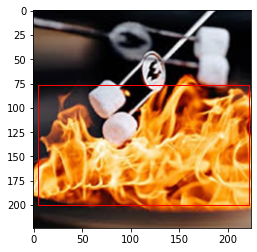

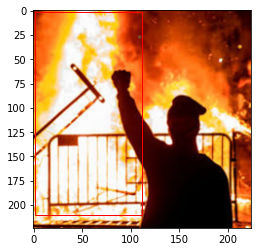

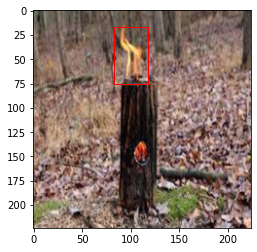

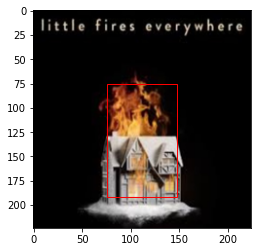

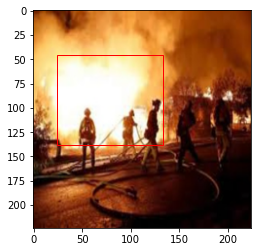

In [19]:
for image, gt in val_dataset.take(5):
    x = gt[:,0]
    y = gt[:,1]
    w = gt[:,2]
    h = gt[:,3]
    xmin = x[0].numpy() - w[0].numpy()/2.
    ymin = y[0].numpy() - h[0].numpy()/2.
    rect_x = int(xmin * IMG_SIZE)
    rect_y = int(ymin * IMG_SIZE)
    rect_w = int(w[0].numpy() * IMG_SIZE)
    rect_h = int(h[0].numpy() * IMG_SIZE)
    
    rect = Rectangle((rect_x, rect_y),rect_w, rect_h, fill=False, color='red')
    plt.axes().add_patch(rect)
    plt.imshow(image[0])
    plt.show()

## Model

In [20]:
def create_model():
    model = tf.keras.Sequential()
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu',padding='SAME', input_shape=(IMG_SIZE,IMG_SIZE,3)))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu',padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu',padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu',padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu',padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1024, activation='relu'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(4,activation='sigmoid'))
    return model

In [21]:
def loss_fn(y_true,y_pred):
    return keras.losses.MeanSquaredError()(y_true,y_pred)

In [22]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 256)       2

## 학습

In [23]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                         decay_steps=steps_per_epoch*2,
                                                         decay_rate=0.5,
                                                         staircase=True)
model.compile(keras.optimizers.RMSprop(lr_schedule),loss=loss_fn)

In [24]:
model.fit(train_dataset, steps_per_epoch=steps_per_epoch,
         epochs=N_EPOCHS,
         validation_data=val_dataset,
         validation_steps=validation_step)

Epoch 1/30
131/131 [==============================] - 49s 364ms/step - loss: 0.0327 - val_loss: 0.0469
Epoch 2/30
131/131 [==============================] - 48s 365ms/step - loss: 0.0225 - val_loss: 0.0415
Epoch 3/30
131/131 [==============================] - 48s 364ms/step - loss: 0.0192 - val_loss: 0.0393
Epoch 4/30
131/131 [==============================] - 47s 357ms/step - loss: 0.0162 - val_loss: 0.0422
Epoch 5/30
131/131 [==============================] - 51s 390ms/step - loss: 0.0153 - val_loss: 0.0354
Epoch 6/30
131/131 [==============================] - 47s 360ms/step - loss: 0.0144 - val_loss: 0.0360
Epoch 7/30
131/131 [==============================] - 47s 354ms/step - loss: 0.0130 - val_loss: 0.0340
Epoch 8/30
131/131 [==============================] - 53s 405ms/step - loss: 0.0125 - val_loss: 0.0330
Epoch 9/30
131/131 [==============================] - 50s 376ms/step - loss: 0.0117 - val_loss: 0.0326
Epoch 10/30
131/131 [==============================] - 47s 355ms/step - l

## 예측

<ipython-input-25-cdeb771004ce>:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().add_patch(pred_rect)


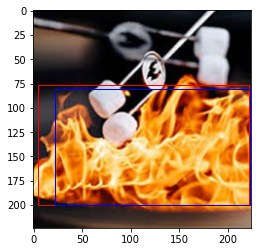

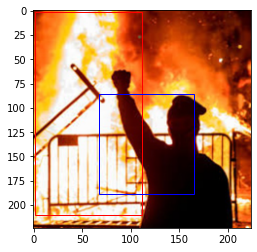

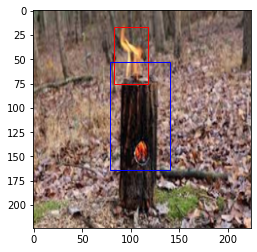

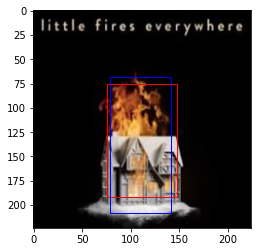

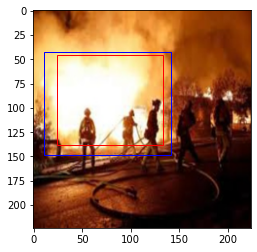

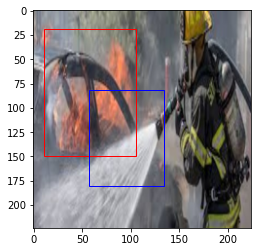

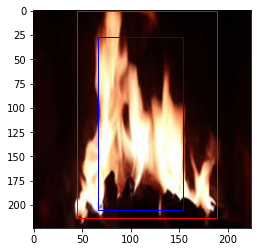

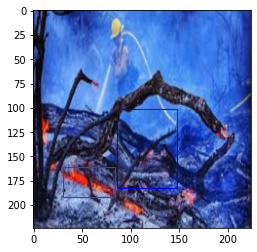

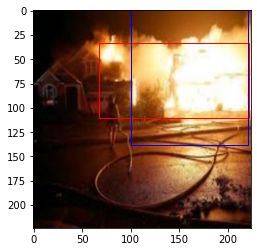

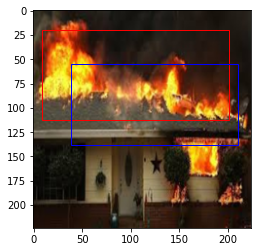

In [25]:
idx = 0
num_imgs = validation_step
for val_data, val_gt in val_dataset.take(num_imgs):
    x = val_gt[:,0]
    y = val_gt[:,1]
    w = val_gt[:,2]
    h = val_gt[:,3]
    xmin = x[idx].numpy() - w[idx].numpy()/2.
    ymin = y[idx].numpy() - h[idx].numpy()/2.
    rect_x = int(xmin * IMG_SIZE)
    rect_y = int(ymin * IMG_SIZE)
    rect_w = int(w[idx].numpy() * IMG_SIZE)
    rect_h = int(h[idx].numpy() * IMG_SIZE)
    
    rect = Rectangle((rect_x, rect_y),rect_w, rect_h, fill=False, color='red')
    plt.axes().add_patch(rect)
    
    
    prediction = model.predict(val_data)
    pred_x = prediction[:,0]
    pred_y = prediction[:,1]
    pred_w = prediction[:,2]
    pred_h = prediction[:,3]
    pred_xmin = pred_x[idx] - pred_w[idx]/2.
    pred_ymin = pred_y[idx] - pred_h[idx]/2.
    pred_rect_x = int(pred_xmin * IMG_SIZE)
    pred_rect_y = int(pred_ymin * IMG_SIZE)
    pred_rect_w = int(pred_w[idx] * IMG_SIZE)
    pred_rect_h = int(pred_h[idx] * IMG_SIZE)
    
    pred_rect = Rectangle((pred_rect_x, pred_rect_y),pred_rect_w, pred_rect_h, fill=False, color='blue')
    plt.axes().add_patch(pred_rect)
    
    plt.imshow(val_data[idx])
    plt.show()

## IOU(Intersection Over Union) 계산

In [26]:
avg_iou = 0
num_imgs = validation_step
res = N_VAL % N_BATCH
for i, (val_data, val_gt) in enumerate(val_dataset.take(num_imgs)):
    flag = (i == validation_step-1)
    x = val_gt[:,0]
    y = val_gt[:,1]
    w = val_gt[:,2]
    h = val_gt[:,3]
    prediction = model.predict(val_data)
    pred_x = prediction[:,0]
    pred_y = prediction[:,1]
    pred_w = prediction[:,2]
    pred_h = prediction[:,3]
    for idx in range(N_BATCH):
        if(flag):
            if idx == res:
                flag == False
                break
        xmin = int((x[idx].numpy() - w[idx].numpy()/2.)*IMG_SIZE)
        ymin = int((y[idx].numpy() - h[idx].numpy()/2.)*IMG_SIZE)
        xmax = int((x[idx].numpy() + w[idx].numpy()/2.)*IMG_SIZE)
        ymax = int((y[idx].numpy() + h[idx].numpy()/2.)*IMG_SIZE)
        
        pred_xmin = int((pred_x[idx] - pred_w[idx]/2.)*IMG_SIZE)
        pred_ymin = int((pred_y[idx] - pred_h[idx]/2.)*IMG_SIZE)
        pred_xmax = int((pred_x[idx] + pred_w[idx]/2.)*IMG_SIZE)
        pred_ymax = int((pred_y[idx] + pred_h[idx]/2.)*IMG_SIZE)
        
        if xmin > pred_xmax or xmax < pred_xmin:
            continue
        if ymin > pred_ymax or ymax < pred_ymin:
            continue
        
        w_union = np.max((xmax, pred_xmax)) - np.min((xmin,pred_xmin))
        h_union = np.max((ymax, pred_ymax)) - np.min((ymin,pred_ymin))
        w_inter = np.min((xmax, pred_xmax)) - np.max((xmin,pred_xmin))
        h_inter = np.min((ymax, pred_ymax)) - np.max((ymin,pred_ymin))
        
        w_sub1 = np.abs(xmax - pred_xmax)
        h_sub1 = np.abs(ymax - pred_ymax)
        w_sub2 = np.abs(xmin - pred_xmin)
        h_sub2 = np.abs(ymin - pred_ymin)
        
        iou = (w_inter * h_inter) / ((w_union * h_union) - (w_sub1 * h_sub1) - (w_sub2 * h_sub2))
        avg_iou += iou /N_VAL
print(avg_iou)
    

0.3703672159431136


In [27]:
test_img_dir = os.path.join(cur_dir,'data/CAMERA/1')
test_imgs = [imgname for imgname in os.listdir(test_img_dir) if os.path.splitext(imgname)[-1] == '.jpg']
for img in test_imgs:
    img_path = os.path.join(test_img_dir,img)
    image = Image.open(img_path)
    image_mode = image.mode
    if image_mode != 'RGB':
        print(img, image_mode)
        image = np.asarray(image)
        print(image.shape)
        os.remove(img_path)

test_imgs = [imgname for imgname in os.listdir(test_img_dir) if os.path.splitext(imgname)[-1] == '.jpg']

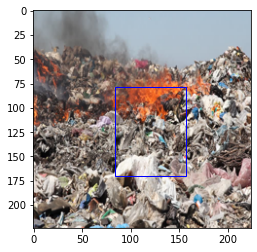

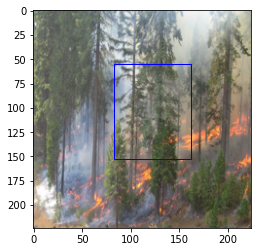

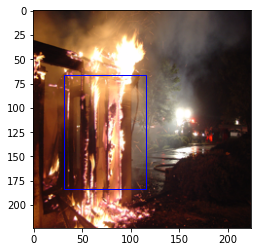

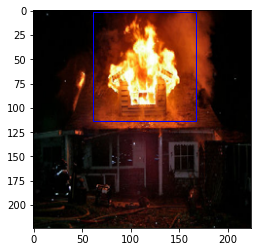

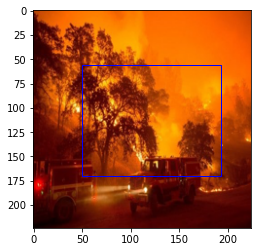

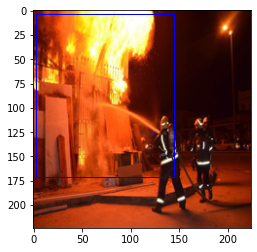

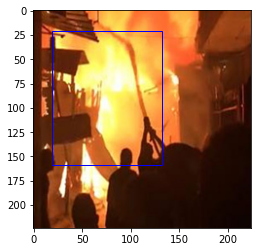

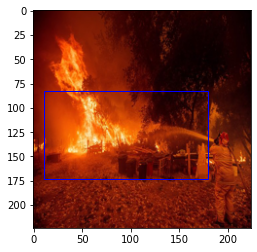

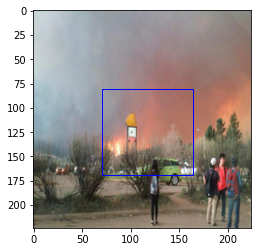

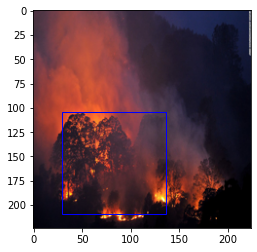

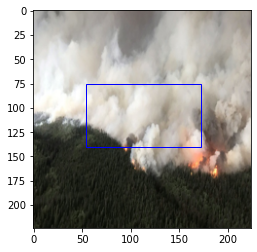

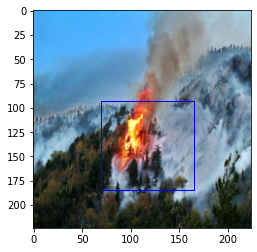

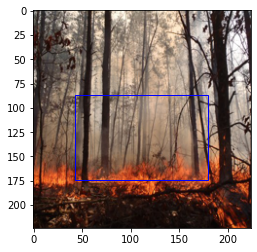

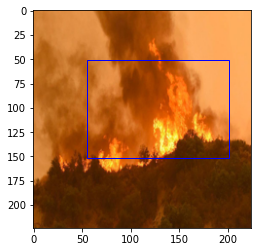

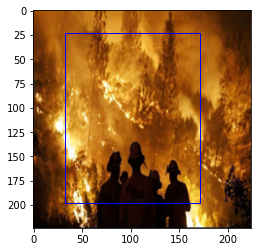

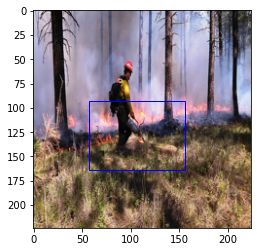

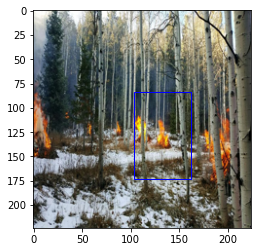

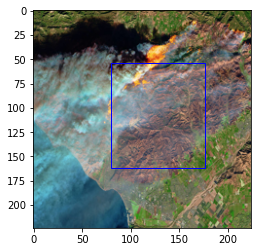

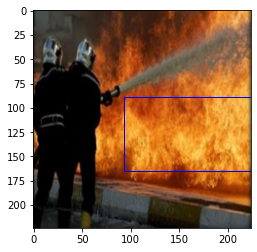

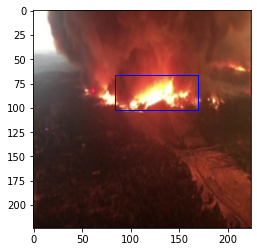

In [28]:
for file in test_imgs[:20]:
    img_path = os.path.join(test_img_dir,file)
    image = Image.open(img_path)
    image = image.resize((IMG_SIZE, IMG_SIZE))
    image = tf.cast(np.array(image), tf.float32)/255.
    image = image[tf.newaxis,...]
    prediction = model.predict(image)
    pred_x = prediction[:,0]
    pred_y = prediction[:,1]
    pred_w = prediction[:,2]
    pred_h = prediction[:,3]
    
    pred_xmin = pred_x - pred_w/2.
    pred_ymin = pred_y - pred_h/2.
    pred_rect_x = int(pred_xmin * IMG_SIZE)
    pred_rect_y = int(pred_ymin * IMG_SIZE)
    pred_rect_w = int(pred_w * IMG_SIZE)
    pred_rect_h = int(pred_h * IMG_SIZE)
    
    pred_rect = Rectangle((pred_rect_x, pred_rect_y),pred_rect_w, pred_rect_h, fill=False, color='blue')
    plt.axes().add_patch(pred_rect)
    
    plt.imshow(image[0])
    plt.show()

In [29]:
model.save('./model/Localization_Model')
model.save_weights('./model/Localization_Model_weights.h5')

INFO:tensorflow:Assets written to: ./model/Localization_Model\assets


In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 256)       2